In [7]:

import numpy as np 
import matplotlib.pyplot as plt


def FastIAST(P_gas,T,y1,y2,y3,y4,y5,N):
    IP1_CH4                               = 0.0016     #kmol/kg
    IP2_CH4                               = 0          #1/bar
    IP3_CH4                               = 4.2E-05    #1/bar
    IP4_CH4                               = 2922.78    #K

    IP1_C2H6                              = 0.0027     #kmol/kg
    IP2_C2H6                              = 0.0        #1/bar 
    IP3_C2H6                              = 2.66E-04   #1/bar
    IP4_C2H6                              = 2833.77    # K

    IP1_C3H8                              = 0.0062     #kmol/kg
    IP2_C3H8                              = 0.0        #1/bar 
    IP3_C3H8                              = 3.75E-04   #1/bar
    IP4_C3H8                              = 2795.28    #K

    IP1_C4H10                             = 0.007      #kmol/kg
    IP2_C4H10                             = 0.0        #1/bar 
    IP3_C4H10                             = 0.0015     #1/bar
    IP4_C4H10                             = 2600       #K

    IP1_CO2                               = 0.0028     #kmol/kg
    IP2_CO2                               = 0.0        #(kmol/kg)/bar 
    IP3_CO2                               = 0.000748   #1/bar
    IP4_CO2                               = 2084.44    #K

    
    Q1 = IP1_CH4 - IP2_CH4*T # Isotherm max capacity CH4
    Q2 = IP1_C2H6 - IP2_C2H6*T # Isotherm max capacity C2H6
    Q3 = IP1_C3H8 - IP2_C3H8*T # Isotherm max capacity C3H8
    Q4 = IP1_C4H10 - IP2_C4H10*T # Isotherm max capacity C4H10
    Q5 = IP1_CO2 - IP2_CO2*T # Isotherm max capacity CO2



    b1 = IP3_CH4*np.exp(IP4_CH4/T) # Isotherm affinity coeff. CH4
    b2 = IP3_C2H6*np.exp(IP4_C2H6/T) # Isotherm affinity coeff. C2H6
    b3 = IP3_C3H8*np.exp(IP4_C3H8/T) # Isotherm affinity coeff. C3H8
    b4 = IP3_C4H10*np.exp(IP4_C4H10/T) # Isotherm affinity coeff. C4H10
    b5 = IP3_CO2*np.exp(IP4_CO2/T) # Isotherm affinity coeff. CO2

    error = 0 # 1 - there was an error in the programm, 0 - OK
    N = 5 # Number of components
    #Langmuir Isotherm
    SingleComponentCapacity = np.array([Q1,Q2,Q3,Q4,Q5]) #Langmuir Isotherm capacity of every component
    AffinityCoefficient = np.array([b1,b2,b3,b4,b5]) #Langmuir Affinity Coefficient of every component
    fractionGas = np.array([y1,y2,y3,y4,y5]) #Gas fraction of every component

    #Initialization
    fastiastGraphConcentration = np.zeros(N)
    fastiastGraphFraction = np.zeros(N)
    fastiastPressure = 0
    adsorbedFraction = np.zeros(N)
    adsorbedConcentration = np.zeros(N)

    #Checking..
    if (len(fractionGas) < N or len(SingleComponentCapacity) < N or len(AffinityCoefficient) < N):
        print("You have the incorrect number of components")
        error = 1

    ###Calculation###

    kappa_old = np.zeros(N)
    delta_kappa = np.ones(N)
    kappa = np.zeros(N)
    CmuT = 0


    partialPressureComponents = fractionGas*P_gas
    for k in range(N):
        CmuT += SingleComponentCapacity[k]*AffinityCoefficient[k]*partialPressureComponents[k]

    for k in range(N):
        kappa[k] = CmuT/(SingleComponentCapacity[k])

    i = 0
    while np.any((delta_kappa) > 1e-4):
        f = np.zeros(N)
        fDerivative = np.zeros(N)
        g = np.zeros(N)
        sigma = np.zeros(N)
        phi = np.zeros((N,N))
        phi = np.matrix(phi)

        for k in range(N):
            f[k] = SingleComponentCapacity[k]*(np.log(1+kappa[k]))
            fDerivative[k] = SingleComponentCapacity[k]*(1/(1+kappa[k]))

        for k in range(N-1):
            g[k] = f[k] - f[k+1]
        for k in range(N):
            g[N-1] += AffinityCoefficient[k]*partialPressureComponents[k]/kappa[k]
        g[N-1] = g[N-1] - 1 


        for k in range(N-1):
            phi[k,k] = fDerivative[k]
            phi[k,k+1] = -fDerivative[k+1]
        for k in range(0,N):
            phi[N-1,k] = - (AffinityCoefficient[k]*partialPressureComponents[k]/(kappa[k]**2))

        sigma = np.linalg.solve(phi, g)
        kappa_old = kappa
        kappa = kappa_old - sigma

        delta_kappa = np.abs(kappa-kappa_old)


        i += 1
        if i > 20 or np.any(kappa<0):
            print("No convergence")
            error = 1
            break
        if np.any(kappa < 0):
            print("No convergence")
            error = 1
            break
        adsorbedFraction = partialPressureComponents*AffinityCoefficient/kappa
        adsorbedConcentrationPure = SingleComponentCapacity*(kappa
                                      /(1+kappa))  
        
        C_total = 0
        for k in range(0,N):
            C_total += ( (adsorbedFraction[k]) / adsorbedConcentrationPure[k])
        C_total = 1/C_total
        adsorbedConcentration =  C_total*adsorbedFraction   

    fastiastGraphConcentration=np.vstack((fastiastGraphConcentration, adsorbedConcentration))
    fastiastGraphFraction=np.vstack((fastiastGraphFraction, adsorbedFraction))
    fastiastPressure=np.vstack((fastiastPressure, P_gas))
    if error == 0:
    ###Result###
        return(fastiastGraphConcentration[1,:])
    else:
        return(0)

 
FastIAST(2,298,0.5,0,0,0,0,5)

array([0.00069271, 0.        , 0.        , 0.        , 0.        ])

In [16]:
def ExtendedLangmuir(P_gas,T,y1,y2,y3,y4,y5,y6):
    IP1_CH4                               = 0.0016     #kmol/kg
    IP2_CH4                               = 0          #1/bar
    IP3_CH4                               = 4.2E-05    #1/bar
    IP4_CH4                               = 2922.78    #K

    IP1_C2H6                              = 0.0027     #kmol/kg
    IP2_C2H6                              = 0.0        #1/bar 
    IP3_C2H6                              = 2.66E-04   #1/bar
    IP4_C2H6                              = 2833.77    # K

    IP1_C3H8                              = 0.0062     #kmol/kg
    IP2_C3H8                              = 0.0        #1/bar 
    IP3_C3H8                              = 3.75E-04   #1/bar
    IP4_C3H8                              = 2795.28    #K

    IP1_C4H10                             = 0.007      #kmol/kg
    IP2_C4H10                             = 0.0        #1/bar 
    IP3_C4H10                             = 0.0015     #1/bar
    IP4_C4H10                             = 2600       #K

    IP1_CO2                               = 0.0028     #kmol/kg
    IP2_CO2                               = 0.0        #(kmol/kg)/bar 
    IP3_CO2                               = 0.000748   #1/bar
    IP4_CO2                               = 2084.44    #K

    IP1_N2                                = 0*0.0075     #kmol/kg
    IP2_N2                                = 0.0        #(kmol/kg)/bar 
    IP3_N2                                = 0.00099    #1/bar
    IP4_N2                                = 0*935.77     #K
    
        
    Q1 = IP1_CH4 - IP2_CH4*T # Isotherm max capacity CH4
    Q2 = IP1_C2H6 - IP2_C2H6*T # Isotherm max capacity C2H6
    Q3 = IP1_C3H8 - IP2_C3H8*T # Isotherm max capacity C3H8
    Q4 = IP1_C4H10 - IP2_C4H10*T # Isotherm max capacity C4H10
    Q5 = IP1_CO2 - IP2_CO2*T # Isotherm max capacity CO2
    Q6 = 0  # Isotherm max capacity N2


    b1 = IP3_CH4*np.exp(IP4_CH4/T) # Isotherm affinity coeff. CH4
    b2 = IP3_C2H6*np.exp(IP4_C2H6/T) # Isotherm affinity coeff. C2H6
    b3 = IP3_C3H8*np.exp(IP4_C3H8/T) # Isotherm affinity coeff. C3H8
    b4 = IP3_C4H10*np.exp(IP4_C4H10/T) # Isotherm affinity coeff. C4H10
    b5 = IP3_CO2*np.exp(IP4_CO2/T) # Isotherm affinity coeff. CO2
    b6 = IP3_N2*np.exp(IP4_N2/T) # Isotherm affinity coeff. N2
    
    N = 6
    y = [y1,y2,y3,y4,y5,y6]
    Affinity = [b1,b2,b3,b4,b5,b6]
    Q = [Q1,Q2,Q3,Q4,Q5,Q6]
    adsorbed = np.zeros(N)

    for i in range(N):
        adsorbed[i] = Q[i]*y[i]*Affinity[i]*P_gas/(1+y[0]*Affinity[0]*P_gas + y[1]*Affinity[1]*P_gas + y[2]*Affinity[2]*P_gas + 
                                             y[3]*Affinity[3]*P_gas + y[4]*Affinity[4]*P_gas + y[5]*Affinity[5]*P_gas )
    return adsorbed

ExtendedLangmuir(10,298,1,0,0,0,0,0)

array([0.00141471, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

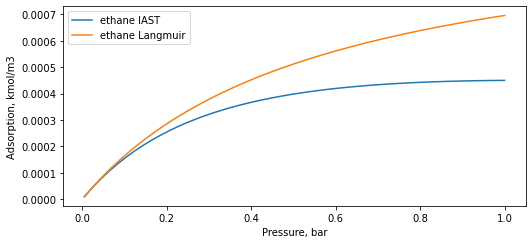

In [18]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
resultPlot1 = np.zeros(5)
resultPlot2 = np.zeros(6)
N = 5
y1 = 0.1
y2 = 0.2
y3 = 0.1
y4 = 0.05
y5 = 0.1
y6 = 1 - y1 - y2 - y3 - y4 - y5
P = np.linspace(0.005,1,50)
for P_gas in P:
    resultPlot1 = np.vstack((resultPlot1, FastIAST(P_gas,298,y1,y2,y3,y4,y5,N)))
    resultPlot2 = np.vstack((resultPlot2, ExtendedLangmuir(P_gas,298,y1,y2,y3,y4,y5,y6)))


#plt.plot(P,resultPlot1[1:,0], label = "methane IAST")
plt.plot(P,resultPlot1[1:,1], label = "ethane IAST")
#plt.plot(P,resultPlot1[1:,2], label = "propane IAST")
#plt.plot(P,resultPlot1[1:,3], label = "butane IAST")
#plt.plot(P,resultPlot1[1:,4], label = "CO2 IAST")
#plt.plot(P,resultPlot1[1:,5], label = "N2 IAST")

#plt.plot(P,resultPlot2[1:,0], label = "methane Langmuir")
plt.plot(P,resultPlot2[1:,1], label = "ethane Langmuir")
#plt.plot(P,resultPlot2[1:,2], label = "propane Langmuir")
#plt.plot(P,resultPlot2[1:,3], label = "butane Langmuir")
#plt.plot(P,resultPlot2[1:,4], label = "CO2 Langmuir")
#plt.plot(P,resultPlot2[1:,5], label = "N2 Langmuir")
plt.xlabel("Pressure, bar")
plt.ylabel("Adsorption, kmol/m3")
plt.legend()
